# Detecting Literary Themes in James Joyce's Works Using Natural Language Processing

Can contemporary Natural Language Processing (NLP) techniques accurately detect early twentieth century literary themes? Let's find out by using the NLP techniques of sentiment analysis, TF-IDF weighting, topic modeling and bigram networks on the works of the 20th Century Irish writer James Joyce. Two of Joyce's early major works, the short story collection *Dubliners* (1914) and the novel *A Portrait of the Artist as a Young Man* (1916), are set in Dublin, Ireland and focus on themes of identity, religion, death, exile and Irish nationalism. How well do these NLP techniques surface words associated with this collection of topics?

## Project Notes

Project Notebooks Execution Order:

1. [clean-and-preprocess-data.ipynb](clean-and-preprocess-data.ipynb)
2. natural-language-processing.ipynb

# Import Packages and Modules

In [1]:
import os
import pickle

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import markovify
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import nltk
import pandas as pd
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Settings

Configure settings for notebook, plots and files. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Plot settings
alpha_mpl = 0.75
alpha_line = 0.75
alpha_fill = 0.2
line_width = 2.5
color_cycle = ['dodgerblue', 'orange', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('../data/raw/')
data_processed = os.path.abspath('../data/processed/')

# Import Processed Data

Before running any of the cells below, run the `clean-and-preprocess-data.ipynb` notebook, which cleans the data, preprocesses the data and writes the data to the `data_processed` directory.

In [3]:
def import_csv(data, data_processed=data_processed, m_index=None):
    '''Import CSV file as a Data Frame.

    Parameters
    ----------
    data: str
        Filename of CSV file in data_processed directory.
    m_index: list
        List of Data Frame columns to use in setting multi index.

    Returns
    -------
    df: pd.DataFrame
        Data Frame of CSV data.
    '''
    path_csv = os.path.join(data_processed, data)
    csv_not_found = ('CSV file does not exist. Verify file was generated by '
                     'clean-and-preprocess-data.ipynb')

    try:
        df = pd.read_csv(path_csv, sep=',', header=0)
    except IOError:
        print(csv_not_found)
        raise
    
    if m_index:
        df.set_index(m_index, inplace=True)
    print(df.shape)
    print(df.dtypes)

    display(df.head(3))
    display(df.sample(3))
    display(df.tail(3))
    
    return df

Import `df_proc_terms`.

In [4]:
df_proc_terms = import_csv('df-proc-terms.csv', m_index=['title', 'chapter'])

(70873, 11)
term             object
anger           float64
anticipation    float64
disgust         float64
fear            float64
joy             float64
negative        float64
positive        float64
sadness         float64
surprise        float64
trust           float64
dtype: object


term  anger  anticipation  disgust  fear  joy  negative  \
title     chapter                                                             
dubliners 1         hope    0.0           1.0      0.0   0.0  1.0       0.0   
          1         time    0.0           1.0      0.0   0.0  0.0       0.0   
          1        third    NaN           NaN      NaN   NaN  NaN       NaN   

                   positive  sadness  surprise  trust  
title     chapter                                      
dubliners 1             1.0      0.0       1.0    1.0  
          1             0.0      0.0       0.0    0.0  
          1             NaN      NaN       NaN    NaN

term  anger  anticipation  disgust  fear  joy  \
title     chapter                                                         
portrait  4        expressions    NaN           NaN      NaN   NaN  NaN   
          4              poise    0.0           0.0      0.0   0.0  0.0   
dubliners 6              begin    0.0           0.0      0.0   0.0  0.0   

                   negative  positive  sadness  surprise  trust  
title     chapter                                                
portrait  4             NaN       NaN      NaN       NaN    NaN  
          4             0.0       0.0      0.0       0.0    0.0  
dubliners 6             0.0       0.0      0.0       0.0    0.0

term  anger  anticipation  disgust  fear  joy  negative  \
title    chapter                                                               
portrait 5           1904    NaN           NaN      NaN   NaN  NaN       NaN   
         5        trieste    NaN           NaN      NaN   NaN  NaN       NaN   
         5           1914    NaN           NaN      NaN   NaN  NaN       NaN   

                  positive  sadness  surprise  trust  
title    chapter                                      
portrait 5             NaN      NaN       NaN    NaN  
         5             NaN      NaN       NaN    NaN  
         5             NaN      NaN       NaN    NaN

Import `df_raw_chptrs`.

In [5]:
df_raw_chptrs = import_csv('df-raw-chptrs.csv')

(20, 3)
chapter     int64
text       object
title      object
dtype: object


,chapter,text,title
0,1,There was no hope for him this time: it was t...,dubliners
1,2,It was Joe Dillon who introduced the Wild Wes...,dubliners
2,3,"North Richmond Street, being blind, was a qui...",dubliners


,chapter,text,title
12,13,"Mr Holohan, assistant secretary of the Eire A...",dubliners
15,1,Once upon a time and a very good time it was ...,portrait
6,7,Mrs Mooney was a butcher’s daughter. She was ...,dubliners


,chapter,text,title
17,3,The swift December dusk had come tumbling clo...,portrait
18,4,Sunday was dedicated to the mystery of the Ho...,portrait
19,5,He drained his third cup of watery tea to the...,portrait


Import `df_tf`.

In [6]:
df_tf = import_csv('df-tf.csv', m_index=['title', 'chapter'])

(26708, 12)
term             object
freq              int64
anger           float64
anticipation    float64
disgust         float64
fear            float64
joy             float64
negative        float64
positive        float64
sadness         float64
surprise        float64
trust           float64
dtype: object


term  freq  anger  anticipation  disgust  fear  joy  \
title     chapter                                                           
dubliners 1           1895     1    NaN           NaN      NaN   NaN  NaN   
          1            1st     1    NaN           NaN      NaN   NaN  NaN   
          1        absolve     1    NaN           NaN      NaN   NaN  NaN   

                   negative  positive  sadness  surprise  trust  
title     chapter                                                
dubliners 1             NaN       NaN      NaN       NaN    NaN  
          1             NaN       NaN      NaN       NaN    NaN  
          1             NaN       NaN      NaN       NaN    NaN

term  freq  anger  anticipation  disgust  fear  joy  \
title    chapter                                                           
portrait 4        beneath     3    0.0           0.0      0.0   0.0  0.0   
         2        furnish     1    0.0           0.0      0.0   0.0  0.0   
         5           limp     2    0.0           0.0      0.0   0.0  0.0   

                  negative  positive  sadness  surprise  trust  
title    chapter                                                
portrait 4             0.0       0.0      0.0       0.0    0.0  
         2             0.0       0.0      0.0       0.0    0.0  
         5             1.0       0.0      0.0       0.0    0.0

term  freq  anger  anticipation  disgust  fear  joy  \
title    chapter                                                              
portrait 5          zacchary     1    NaN           NaN      NaN   NaN  NaN   
         5        zincroofed     1    NaN           NaN      NaN   NaN  NaN   
         5           zoology     1    0.0           0.0      0.0   0.0  0.0   

                  negative  positive  sadness  surprise  trust  
title    chapter                                                
portrait 5             NaN       NaN      NaN       NaN    NaN  
         5             NaN       NaN      NaN       NaN    NaN  
         5             0.0       0.0      0.0       0.0    0.0

Import `dubliners_raw_chptr` and `portrait_raw_chptr`.

In [7]:
def import_raw_novels(pickle_file, novel_title, data_processed=data_processed):
    '''Import pickled raw chapters.
    
    Parameters
    ----------
    pickle_file : str
        Filename of pickle object.
    novel_title : str
        Title of pickled novel.
    
    Returns
    -------
    raw_chapters : list of lists of str
        One chapter per sublist within list.
    '''
    path_txt_chptr = os.path.join(data_processed, pickle_file)
    try:
        with open(path_txt_chptr, 'rb') as fp:
            raw_chptrs = pickle.load(fp)
    except IOError:
        print('{} does not exist. Verify file was generated by '
              'clean-and-preprocess-data.ipynb'
              .format(path_txt_chptr))
        raise

    print(novel_title)
    print(raw_chptrs[0][:50])
    print(raw_chptrs[-1][-51:])
    print('\n')

    return raw_chptrs

dubliners_raw_chptr = import_raw_novels('dubliners-raw-chptr', 'Dubliners')
portrait_raw_chptr = import_raw_novels('portrait-raw-chptr', 'Portrait')

Dubliners
 There was no hope for him this time: it was the t
 their last end, upon all the living and the dead. 


Portrait
 Once upon a time and a very good time it was ther
d ever in good stead. Dublin, 1904. Trieste, 1914. 




# Analysis

## Sentiment Analysis

Sentiment Analysis identifies subjective attitudes, such as positive or negative emotion, in source materials. The materials in the case of this analysis are literary works. Identify the top most frequent positive and negative words in *Dubliners* and *Portrait* using the labeled NRC Emotion Lexicon. This approach to identifying topics is simple and unsophisticated, but it still reveals essential elements in Joyce's themes, such as identity as it relates to family, religion and death. We'll improve on this approach later in the analysis with more refined techniques to identify topics.

What are the most frequent positive and negative terms in each work?

In [8]:
def top_freq_terms(sentiment, top_n, df_tf=df_tf):
    '''Create pandas data frame of most frequent terms.

    Parameters
    ----------
    sentiment : str
        Label used to assign name to index level.
    top_n : int
        Number of top terms to return.

    Returns
    -------
    df_top : pd.DataFrame
        Data frame of top terms, either positive or negative.
    '''
    df = (df_tf[df_tf[sentiment] == 1]
          .groupby(['title', 'term'])['freq']
          .sum()
          .to_frame('freq')
          .sort_values('freq', ascending=False)
          .reset_index(level='term')
          .groupby('title')
          .head(top_n)
          .sort_values(['title', 'freq'], ascending=[True, False])['term']
          .reset_index())

    cols_top = df_tf.index.get_level_values(level=0).unique().tolist()
    df_top = pd.DataFrame(columns=cols_top)

    for title in cols_top:
        df_top[title] = df[df['title'] == title]['term'].values

    df_top.index.name = 'top_{}'.format(sentiment)
    df_top.index = df_top.index + 1

    return df_top

df_tf_top_pos = top_freq_terms('positive', 10)
df_tf_top_neg = top_freq_terms('negative', 10)

df_tf_top_pos
df_tf_top_neg

,dubliners,portrait
top_positive,,
1,aunt,god
2,young,word
3,good,good
4,laugh,mother
5,talk,love
6,word,priest
7,smile,fellow
8,money,laugh
9,sing,smile


,dubliners,portrait
top_negative,,
1,leave,sin
2,wait,cry
3,boy,mother
4,mother,hell
5,fall,leave
6,cry,fall
7,cold,cold
8,small,fear
9,wear,fell


As expected, the most-frequent results include words that could be common across throughout the works, such as "word", "boy" or "talk", and therefore are not as crucial to identifying themes. However, the instances of family relationships (i.e., "aunt" and "mother") point to issues of identity, and the prevalence of words that relate to religion and death are on the right track. We'll improve on this approach later in the analysis.

Side Note: It's interesting to see that the word "mother" is labeled as both positive and negative in the NRC Emotion Lexicon and that it appears in both positive and negative most-frequent lists for both works.

### Sentiment by Chapter

Let's plot at the positive and negative terms in aggregate by grouping the sentiment by chapter. Are positive and negative terms balanced throughout the literary works, or does one sentiment dominate the other in a particular chapter or short story?  

Plot the positive and negative trends lines on a ratio scale so that chapters or short stories with larger word counts do not artificially inflate the raw positive or negative counts.

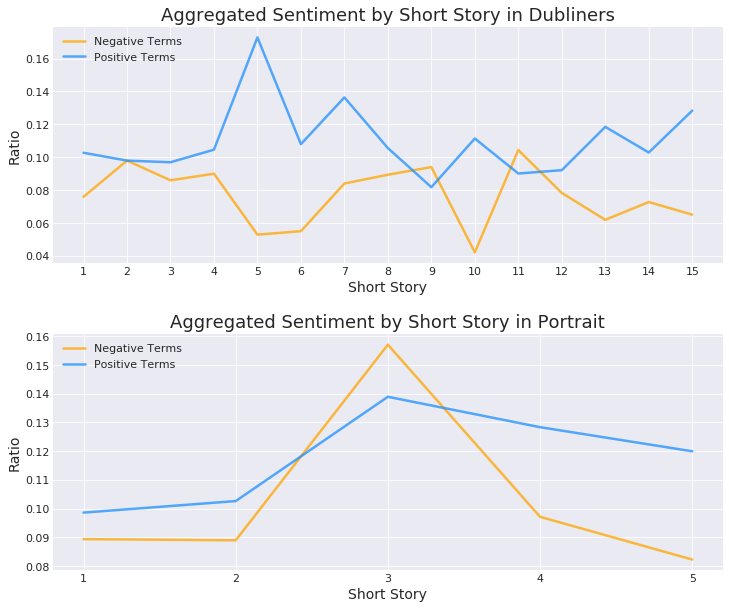

In [9]:
df_pos_neg_norm = (df_proc_terms[['negative', 'positive']]
                   .groupby(['title', 'chapter'])
                   .apply(lambda g: g.sum(skipna=True) / float(g.shape[0])))

fig, ax = plt.subplots(figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)

for idx, novel in enumerate(['dubliners', 'portrait']):

    ax = plt.subplot(2, 1, idx+1)
    
    neg = df_pos_neg_norm.loc[novel]['negative']
    pos = df_pos_neg_norm.loc[novel]['positive']

    ax.plot(neg, color='C1', linewidth=line_width, alpha=alpha_line)
    ax.plot(pos, color='C0', linewidth=line_width, alpha=alpha_line)
    
    xticks_max = df_proc_terms.loc[novel].index.get_level_values(0).max() + 1
    ax.set_xticks(list(range(1, xticks_max)))
    ax.set_title('Aggregated Sentiment by Short Story in {}'.format(novel.title()))
    ax.set_xlabel('Short Story')
    ax.set_ylabel('Ratio')
    ax.legend(['Negative Terms', 'Positive Terms'], loc='upper left')

plt.show();

There is a fair amount of positive and negative variation across *Dubliners*, with a strong positive spike in story five and a strong negative drop in story ten. The *Portrait* graph is much more uniform with a strong spike in both positive and negative terms in the third chapter. It will be interesting to see which topics are associated with these spikes later in the analysis.

### Sentiment by Multi-Paragraph

Group the novel text into groups of words that are smaller than chapters but larger than a paragraphs. This will smooth out the noise that occurs when the text is groped into paragraphs but it will also clarify the peaks and valleys in the plots. 

In [10]:
chunk_size_d = 400
chunk_size_p = 500

df_pos_neg_para_d = df_proc_terms.loc['dubliners'].reset_index().reset_index()
df_pos_neg_para_d = (df_pos_neg_para_d
                     .groupby(by=df_pos_neg_para_d.index // chunk_size_d)
                     .agg({
                         'index': 'min',
                         'chapter': 'min',
                         'positive': 'sum',
                         'negative': 'sum'
                     })
                     .astype(int))

df_pos_neg_para_p = df_proc_terms.loc['portrait'].reset_index().reset_index()
df_pos_neg_para_p = (df_pos_neg_para_p
                     .groupby(by=df_pos_neg_para_p.index // chunk_size_p)
                     .agg({
                         'index': 'min',
                         'chapter': 'min',
                         'positive': 'sum',
                         'negative': 'sum'
                     })
                     .astype(int))

df_pos_neg_para = pd.concat([df_pos_neg_para_d, df_pos_neg_para_p], 
                            keys=['dubliners', 'portrait'])

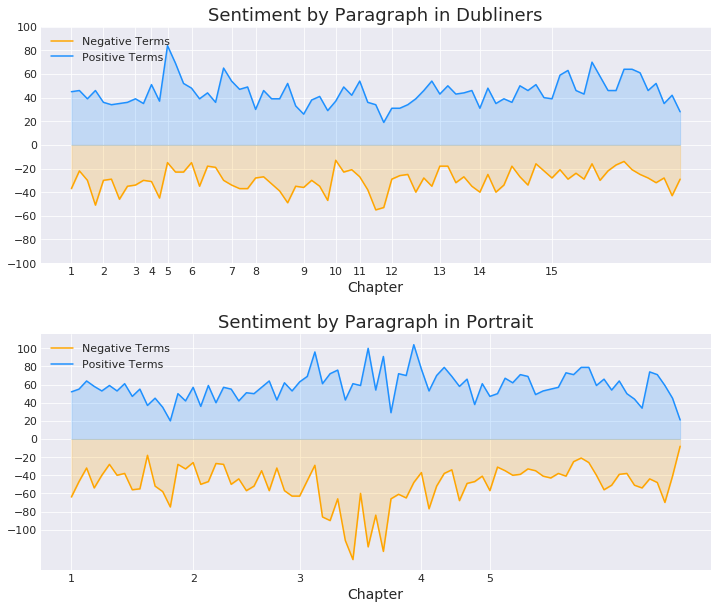

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)

for idx, novel in enumerate(['dubliners', 'portrait']):

    x = df_pos_neg_para.loc[novel].index
    neg = -df_pos_neg_para.loc[novel]['negative']
    pos = df_pos_neg_para.loc[novel]['positive']

    chptr_x_axis = (df_pos_neg_para.loc[novel].groupby('chapter').head(1)
                    .index.tolist())
    
    xticks_max = df_proc_terms.loc[novel].index.get_level_values(0).max() + 1
    
    ax = plt.subplot(2, 1, idx+1)

    ax.fill_between(x, neg, color='C1', alpha=alpha_fill)
    ax.fill_between(x, pos, color='C0', alpha=alpha_fill)
    
    ax.plot(neg, color='C1')
    ax.plot(pos, color='C0')
    
    ax.set_xticks(chptr_x_axis)
    ax.set_yticks(list(range(-100, 101, 20)))
    ax.set_xticklabels(list(range(1, xticks_max)))
    
    ax.set_xlabel('Chapter')
    ax.set_title('Sentiment by Paragraph in {}'.format(novel.title()))
    ax.legend(['Negative Terms', 'Positive Terms'], loc='upper left')

plt.show();

The location of the chapters along the x-axis correspond to the length of those chapters in the literary works. When viewed at the multi-paragraph level, the severe peaks and valleys of the chapter-level plots transform to a relatively steady trade off between positive and negative terms. However, chapter three of *Portrait* is, again, an outlier with relatively severe positive and negative spikes.

Now that we know the general positive and negative sentiment of the chapters, let's see how those peaks and valley correspond to the most relevant words in each chapter using TF-IDF.

## TF-IDF

Use the Term Frequency - Inverse Document Frequency (TF-IDF) score to extract the most important words from each chapter or short story in each work. TF gives us a ratio of the number of times a term appears within a document relative to the total number of terms in the document.  IDF calculates the frequency of a term across the corpus of documents, down-weights terms that are frequent across the corpus and up-weights terms that are infrequent across the corpus.  This prevents frequent words like stop words (e.g., "the", "an", etc.) from being assigned a high rank by TF-IDF. Combining TF and IDF returns a score that balances the frequency of terms within documents against the frequency of terms across all documents in the corpus. 

Calculate the TD-IDF scores for each literary work and review the top 10 terms for each chapter or short story. 

In [12]:
def calc_tfidf_scores(title_lit, df): 
    '''Calculate TF-IDF scores for chapters in a novel.

    Parameters
    ----------
    title_lit : str
        Label for novel. 

    df : pd.DataFrame
        Data Frame of preprocessed chapters in a novel.

    Returns
    -------
    matrix_weights : scipy.sparse.csr.csr_matrix
        Tf-idf-weighted document-term sparse matrix.
    feat_names : list of str
        List of feature names.
    feat_weights : dict {str : float}
        Mapping from feature feature names to TF-IDF weights.
    vocab : dict {int : str}
        Mapping from feature indices to terms.
    '''
    s_chptrs = (df
                .loc[title_lit]
                .groupby('chapter')
                ['term']
                .apply(' '.join)
                .tolist())
    tfidf = TfidfVectorizer(analyzer='word', stop_words='english')
    matrix_weights = tfidf.fit_transform(s_chptrs)

    feat_names = tfidf.get_feature_names()
    feat_weights = tfidf.idf_
    feat_weights = dict(zip(feat_names, feat_weights))

    vocab = tfidf.vocabulary_
    # Invert the dictionary to map the feature indices below.
    vocab = {v: k for k, v in vocab.items()}
    
    return matrix_weights, feat_names, feat_weights, vocab

matrix_wts_d, feat_names_d, feat_wts_d, vocab_d = calc_tfidf_scores(
    'dubliners', df_proc_terms)
matrix_wts_p, feat_names_p, feat_wts_p, vocab_p = calc_tfidf_scores(
    'portrait', df_proc_terms)

In [13]:
def top_feat_cols(title_lit, df):
    '''Create list of column names.

    Column names correspond to the number of chapters in the novel.

    Parameters
    ----------
    title_lit : str
        Label for novel. 
    df : pd.DataFrame
        Data Frame of preprocessed chapters in a novel.

    Returns
    -------
    cols : list
        List of columns names that correspond to number of chapters in 
        novel.
    stop : int
        Maximum number of chapters in novel.
    '''
    stop = df.loc[title_lit].index.get_level_values(level=0).max()
    cols_chptrs = ['chptr_' + str(x) for x in range(1, stop+1)]
    
    return cols_chptrs, stop

def convert_sparse_matrix(title_lit, matrix_weights, vocab, feat_weights, df):
    '''Convert TF-IDF sparse matrix into Sparse Data Frame.

    Sparse Data Frame will be utilized to display top words per chapter.

    Parameters
    ----------
    title_lit : str
        Label for novel. 
    df : pd.DataFrame
        Data Frame of preprocessed chapters in a novel.

    Returns
    -------
    df_weights : pd.SparseDataFrame
        Tf-idf-weighted document-term Sparse Data Frame.
    cols_chptrs : list of str
        List of columns names that correspond to number of chapters in 
        novel.
    '''
    cols_chptrs, stop = top_feat_cols(title_lit, df)
    labels_chptrs = dict(zip(range(0, stop), cols_chptrs))
    
    df_weights = (pd.SparseDataFrame(matrix_weights)
                  .transpose()
                  .rename(labels_chptrs, axis='columns'))
    df_weights[cols_chptrs] = df_weights[cols_chptrs].astype(float)
    
    df_weights['avg_tfidf'] = df_weights.mean(axis='columns')
    df_weights['median_tfidf'] = df_weights.median(axis='columns')
    df_weights['term'] = df_weights.index.to_series().map(vocab)
    df_weights['idf_weight'] = df_weights['term'].map(feat_weights)

    return df_weights, cols_chptrs

df_tfidf_d, cols_chptrs_d = convert_sparse_matrix('dubliners',
                                                  matrix_wts_d,
                                                  vocab_d,
                                                  feat_wts_d,
                                                  df_proc_terms)
df_tfidf_p, cols_chptrs_p = convert_sparse_matrix('portrait',
                                                  matrix_wts_p,
                                                  vocab_p,
                                                  feat_wts_p,
                                                  df_proc_terms)

In [14]:
def top_features(df_tfidf, cols_chptr, top_rows=10):
    '''Identify n top TD-IDF features per chapter.

    Parameters
    ----------
    df_tfidf : pd.SparseDataFrame
        Tf-idf-weighted document-term Sparse Data Frame.
    cols_chptr : list of str
        List of columns names that correspond to number of chapters in
        novel.
    top_rows : int
        Top n rows to return in df_top.

    Returns
    -------
    df_top : pd.DataFrame
        Data Frame of top n features per chapter.
    '''
    df_top = pd.DataFrame()
    for chptr in cols_chptr:
        s_top = (df_tfidf
                 .sort_values(chptr, ascending=False)
                 ['term']
                 .head(top_rows)
                 .reset_index(drop=True))
        df_top[chptr] = s_top
    df_top.index = df_top.index + 1
    return df_top

df_top_tfidf_d = top_features(df_tfidf_d, cols_chptrs_d)
df_top_tfidf_p = top_features(df_tfidf_p, cols_chptrs_p)

df_top_tfidf_d
df_top_tfidf_p

,chptr_1,chptr_2,chptr_3,chptr_4,chptr_5,chptr_6,chptr_7,chptr_8,chptr_9,chptr_10,chptr_11,chptr_12,chptr_13,chptr_14,chptr_15
1,say,say,bazaar,father,car,say,make,say,say,say,decease,say,concert,say,aunt
2,aunt,whip,stall,mother,cars,street,reparation,little,man,nice,dublin,man,say,power,say
3,old,field,uncle,use,men,walk,daughter,child,clerk,children,life,old,daughter,coy,miss
4,nannie,school,house,avenue,hungarian,know,mother,london,pa,tip,death,bottle,miss,man,snow
5,look,boys,say,home,motor,turn,little,friend,office,nextdoor,engine,ask,committee,pope,come
6,poor,butler,aunt,say,young,young,board,paris,stand,cake,paragraph,come,baritone,know,ask
7,know,man,come,buenos,french,note,affair,know,copy,plumcake,railway,little,artistes,constable,goodnight
8,snuff,girls,street,field,money,corner,know,old,desk,bag,blame,think,contract,gentlemen,turn
9,think,come,light,store,father,ginger,young,drink,little,gentleman,chapelizod,vote,tenor,yes,sing
10,coffin,begin,train,come,party,face,madam,whisky,weather,tea,desk,boy,dressingroom,ask,ladies


,chptr_1,chptr_2,chptr_3,chptr_4,chptr_5
1,say,say,god,soul,say
2,father,father,sin,life,temple
3,like,old,soul,priest,come
4,fellows,come,hell,hear,like
5,tell,stand,time,fall,ask
6,come,like,come,make,know
7,make,hear,life,power,eye
8,hand,make,torment,pass,think
9,prefect,little,like,like,esthetic
10,look,know,make,eye,mind


When applied to *Dubliners*, TF-IDF appears to be more useful for identifying plot as opposed to themes. While some words associated with Joyce's themes, such as "coffin", "life", "death", "vote", "pope", "father", "mother", etc., appear in the TF-IDF results, a majority of the terms are more closely aligned with plot points. There's clearly a tea party going on in story 10 and a concert occurring in story 13. In sentiment analysis section, stories 5 and 10 show a positive and a negative spike, respectively. Men celebrating a car race win is the basic plot of story 5, which explains the positive sentiment of the story. An increase in negative words in chaper 10 is less obvious given the words surfaced by TF-IDF; the protagonist of this story mistakenly leaves the plumcake on a tram, among other misfortunes that befall her, which accounts for the associated negative sentiment. 

The TF-IDF results for *Portrait* are much more tightly focused on philosophical or existential words, such as "soul", "esthetic", "mind", "old" and "life". Chapter three is very focused on religion, particularly sin, torment and hell, which correspond to the spike in positive and negative terms in that chapter. The TF-IDF terms for identifying themes in *Portrait* are an improvement over the raw frequencies of positive and negative terms in the Sentiment Analysis section above. 

Let's see how Topic Modeling performs in comparison to TF-IDF.

## Topic Modeling with NMF and LDA

Topic modeling extracts topics, meaning groups of words, that are most representative of the subject matter in documents across a collection or corpus. Let's use two algorithms with different mathematical underpinnings to compare extracted topics: Non-negative Matrix Factorization (NMF) and Latent Dirichlet Allocation (LDA). NMF utilizes linear algebra to produce a set of topics based on weights, such as word counts in the bag-of-words model or TF-IDF weighted counts. LDA utilizes a probabilistic graphical modeling technique to infer topics from documents based on probabilities. 

In [15]:
num_features = 1000
num_topics = 5

def fit_lda(title_lit, df=df_proc_terms, n_features=num_features, 
            n_topics=num_topics):
    '''Fit Latent Dirichlet Allocation model.

    Parameters
    ----------
    title_lit : str
        Label for novel.
    df : pd.DataFrame
        Data Frame of preprocessed chapters in a novel.
    n_features : int
        Number of top features of most frequent terms across the corpus.
    n_topics : int
        Number of topics to return.

    Returns
    -------
    lda : sklearn.decomposition.online_lda.LatentDirichletAllocation object
        Fitted LDA object.
    tf_feat_names : list
        List of feature names.
    '''
    tf_vec = CountVectorizer(max_features=n_features, 
                             stop_words='english')
    s_chptrs = (df.loc[title_lit]
                .groupby('chapter')['term']
                .apply(' '.join)
                .tolist())
    tf = tf_vec.fit_transform(s_chptrs)
    tf_feat_names = tf_vec.get_feature_names()
    lda = LatentDirichletAllocation(n_components=n_topics, 
                                    max_iter=10, 
                                    learning_method='batch').fit(tf)
    
    return lda, tf_feat_names

def fit_nmf(title_lit, df=df_proc_terms, n_features=num_features, 
            n_topics=num_topics):
    '''Fit Non-negative Matrix Factorization model.

    Parameters
    ----------
    title_lit : str
        Label for novel.
    df : pd.DataFrame
        Data Frame of preprocessed chapters in a novel.
    n_features : int
        Number of features to return.
    n_topics : int
        Number of topics to return.

    Returns
    -------
    nmf : sklearn.decomposition.nmf.NMF object
        Fitted NMF object.
    tfidf_feat_names : list
        List of TF-IDF feature names.
    '''
    tfidf_vec = TfidfVectorizer(max_features=n_features, 
                                stop_words='english')
    s_chptrs = (df.loc[title_lit]
                .groupby('chapter')
                ['term']
                .apply(' '.join)
                .tolist())
    tfidf = tfidf_vec.fit_transform(s_chptrs)
    tfidf_feat_names = tfidf_vec.get_feature_names()
    nmf = (NMF(n_components=n_topics).fit(tfidf))
    
    return nmf, tfidf_feat_names


lda_d, tf_feat_names_d = fit_lda('dubliners')
lda_p, tf_feat_names_p = fit_lda('portrait')

nmf_d, tfidf_feat_names_d = fit_nmf('dubliners')
nmf_p, tfidf_feat_names_p = fit_nmf('portrait')

In [16]:
# Temporarily remove maximum column width to display all topics in df.
pd.set_option('display.max_colwidth', -1)

def display_topics(title_lit, model, feature_names, n_top_words=10):
    '''Prettify topics output of models.

    Parameters
    ----------
    title_lit: str
        Label for novel.
    model : sklearn.decomposition.nmf.NMF or 
        sklearn.decomposition.online_lda.LatentDirichletAllocation object.
        Fitted LDA or NMF object.
    feature_names : list of str
        List of feature names.
    n_top_words : int
        Number of topics to return.

    Returns
    -------
    df_topics : pd.DataFrame
        Data frame of model topics.
    '''
    model_topics = []
    for idx, topic in enumerate(model.components_):
        topics = ' '.join([feature_names[i] 
                           for i 
                           in topic.argsort()[:-n_top_words - 1:-1]])
        model_topics.append({title_lit : topics}) 
    df_topics = pd.DataFrame(model_topics)
    return df_topics

df_topics_nmf = display_topics('Dubliners  NMF', nmf_d, tfidf_feat_names_d)
df_topics_lda = display_topics('Dubliners LDA', lda_d, tf_feat_names_d)
df_topics_d = pd.concat([df_topics_nmf, df_topics_lda], axis='columns')
df_topics_d.index.name = 'Topic'
df_topics_d.reset_index(inplace=True)
df_topics_d['Topic'] = df_topics_d['Topic'] + 1

df_topics_nmf = display_topics('Portrait NMF', nmf_p, tfidf_feat_names_p)
df_topics_lda = display_topics('Portrait LDA', lda_p, tf_feat_names_p)
df_topics_p = pd.concat([df_topics_nmf, df_topics_lda], axis='columns')
df_topics_p.index.name = 'Topic'
df_topics_p.reset_index(inplace=True)
df_topics_p['Topic'] = df_topics_p['Topic'] + 1

df_topics_d
df_topics_p

pd.reset_option('max_colwidth')

,Topic,Dubliners NMF,Dubliners LDA
0,1,say man little old know come power ask think tell,say man power little know come make stand coy ask
1,2,decease dublin life death paragraph engine walk time daughter train,say aunt old come ask miss like think know make
2,3,aunt say old miss uncle bazaar come know look nannie,say little know come begin time young house make like
3,4,car men cars hungarian young french money party card good,life dublin time meet little night live read years house
4,5,mother father use house make know home say come little,awkward board bedroom manager judge divide dream disappoint polish outside


,Topic,Portrait NMF,Portrait LDA
0,1,say father like fellows tell come make hand prefect look,weak belt band boyhood tomorrow file drift wrong glad sheet
1,2,soul life priest hear make fall power pass like voice,god soul sin life time come hell make like love
2,3,god sin soul hell time come life torment like heart,say come like know eye ask think mind turn word
3,4,say temple like come ask know eye think esthetic mind,weak belt band boyhood tomorrow file drift wrong glad sheet
4,5,say father old come stand like hear make little know,say father like come make tell little hand look eye


The *Dubliners* NMF and LDA results are fairly similar, with NMF edging out LDA in terms of topics evocative of Joyce's themes, including death and identify through family. Both NMF and LDA accurately reflect the theme of religion in *Portrait*, with NMF again returning topics that more precisely evoke religious or existential themes.

## Bigram Network Diagrams

Visualize the relationships between the most frequent bigrams or pairs of consecutive words. How are the top bigrams connected and do they reveal relationships between words associated with Joyce's themes?

In [17]:
ngram_dubliners = nltk.ngrams(df_proc_terms.loc['dubliners', 'term'], 2)
df_ngram_d = pd.DataFrame(ngram_dubliners)
df_ngram_d.rename({0: 'word_1', 1: 'word_2', 'bigram': 'count'},
                  axis='columns',
                  inplace=True)
df_ngram_d['count'] = (df_ngram_d['word_1'] +
                       ' ' +
                       df_ngram_d['word_2'])
df_top_ngram_d = (df_ngram_d['count']
                  .value_counts()
                  .reset_index())
df_top_ngram_d[['word_1', 'word_2']] = (df_top_ngram_d['index']
                                        .str.split(' ', expand=True))

ngram_portrait = nltk.ngrams(df_proc_terms.loc['portrait', 'term'], 2)
df_ngram_p = pd.DataFrame(ngram_portrait)
df_ngram_p.rename({0: 'word_1', 1: 'word_2', 'bigram': 'count'},
                  axis='columns',
                  inplace=True)
df_ngram_p['count'] = (df_ngram_p['word_1'] +
                       ' ' +
                       df_ngram_p['word_2'])
df_top_ngram_p = (df_ngram_p['count']
                  .value_counts()
                  .reset_index())
df_top_ngram_p[['word_1', 'word_2']] = (df_top_ngram_p['index']
                                        .str.split(' ', expand=True))

/Users/kim/anaconda3/envs/james-joyce-nlp/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


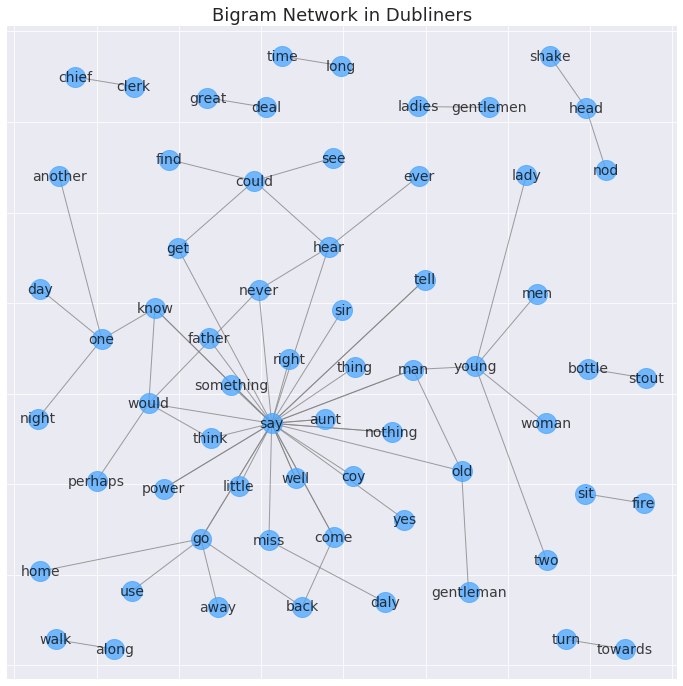

In [18]:
fig, ax = plt.subplots(figsize=(12, 12))

g = nx.DiGraph()

(df_top_ngram_d[df_top_ngram_d['count'] > 6]
 .apply(lambda r: g.add_edge(r['word_1'], r['word_2'], weight=r['count']), 
        axis='columns'))

nx.draw_networkx(g, 
                 pos=graphviz_layout(g, prog='neato', args='-Goverlap=false'),
                 arrows=False, 
                 node_color='#4aa6ff',
                 font_color='black',
                 edge_color='gray',
                 alpha=0.75, 
                 node_size=400, 
                 font_size=14) 
ax.set_title('Bigram Network in Dubliners')
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show();

The word "say" is at the center of the *Dubliners* network, as you might expect in a literary work. "Think" and "power" make appearances near the center of the cluster, as does "aunt" and "father". Otherwise, these bigrams are not as revealing in detecting theme as previous techniques.

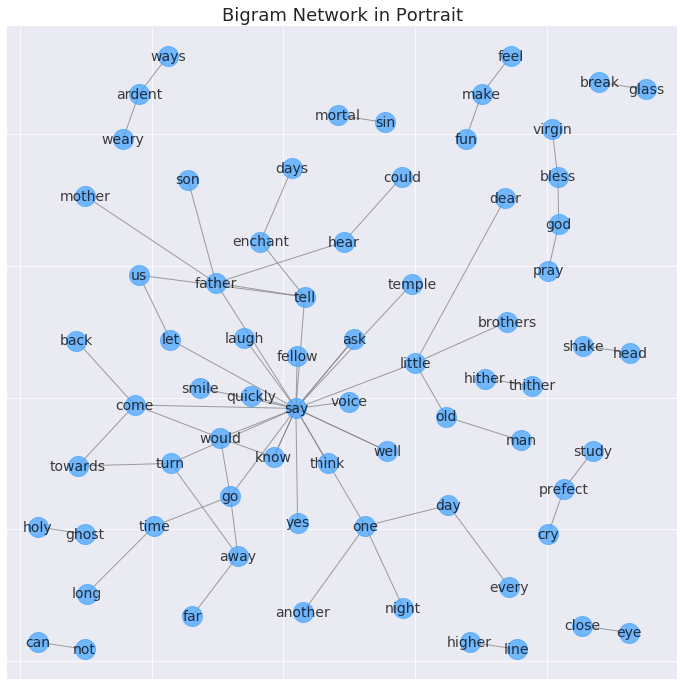

In [19]:
g = nx.DiGraph()

(df_top_ngram_p[df_top_ngram_p['count'] > 6]
 .apply(lambda r: g.add_edge(r['word_1'], r['word_2'], weight=r['count']), 
        axis='columns'))

fig, ax = plt.subplots(figsize=(12, 12))

nx.draw_networkx(g, 
                 pos=graphviz_layout(g, prog='neato', args='-Goverlap=false'),
                 arrows=False, 
                 node_color='#4aa6ff',
                 font_color='black',
                 edge_color='gray',
                 alpha=0.75, 
                 node_size=400, 
                 font_size=14) 
ax.set_title('Bigram Network in Portrait')
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show();

The word "say" is also at the center of the *Portrait* network, with "ask", "think", "voice" and "know" very closely associated. Family members "father", "mother" and "brother" are slightly further out in the graph. Religion makes an appearance in the outer edges of the network, unconnected to the center of the network, and terms describing pathways, such as "come", "towards" and "turn", add a layered element to Joyce's existentialism. Aside from the themes present in this network, the diagrams reveals several amusing bigrams, such as "hither thither" and "break glass". How many times was glass broken in *Portrait*?  

In [20]:
df_top_ngram_p[df_top_ngram_p['index'] == 'break glass']['count'].values[0]

8

## Markov Chain Tweets

Finally, for fun let's create some tweets in the style of Joyce's works using a Markov chain generator. Each time the following code is run, a new set of tweets is generated. Many of the tweets generated by the Markov chain are nonsensical, especially as the length of the generated sentence grows. Limiting the tweets to the old school character limit of 140 characters produces fewer nonsense tweets.

The Markov chain generator utilizes an input corpus to create a dictionary which holds all of the bigrams in the corpus as keys. For each of these bigrams, a nested dictionary is created to hold all of the words in the corpus that follow the bigram and a count of the number of times each of those words follow the bigram. The generator assembles a tweet in a sequential fashion, utilizing the dictionary to lookup the bigram at the current end of the tweet and the bigram's associated words. The generator then randomly selects a word from the associated words and appends it the to the end of the tweet. The process repeats itself until the maximum number of words has been reached. 

In [21]:
pd.set_option('display.max_colwidth', -1)

markov_model_d = markovify.Text(dubliners_raw_chptr)
markov_model_p = markovify.Text(portrait_raw_chptr)

num_chars = 140
   
tweets_d = []
for i in range(3):
    tweets_d.append(markov_model_d.make_short_sentence(num_chars))

tweets_p = []
for i in range(3):
    tweets_p.append(markov_model_p.make_short_sentence(num_chars))

pd.DataFrame({'Dubliners Tweets' : tweets_d})
pd.DataFrame({'Portrait Tweets' : tweets_p})

pd.reset_option('max_colwidth')

,Dubliners Tweets
0,The old man vacated.
1,He longed to be on the table.
2,"“Yes, that’s agreed,” said Ignatius Gallaher on the mantelpiece as soon as possible at some time from the other thing."


,Portrait Tweets
0,They would be in a low whisper of innocent transgressions in the choir.
1,Mr Dedalus had been established between them.
2,"He is looked up quickly and said: —Now then, who will win?"


### Favorites

Here are some of my favorite nonsense, oddball or poetic tweets generated by multiple passes of the Markov chain code above. 

***Dubliners* Tweets:**
* He twisted his features into a tawny glow.
* The two young women with big hats and a black sheep.
* Some girls stood near Emma in a Roman dress with a liquid life; and like a changing glow of pallid brick red.
* I remember seeing your grandfather in his rival’s false smile.
* Do you hear the faint rhythm of beauty.

***Portrait* Tweets:**
* You are a stinkpot.
* Doomsday was at night.
* The water would rise inch by inch, covering the end of the morning light was gathering.
* At the door of the human individual.
* An evil smell, faint and foul to swallow and the scalding tears falling out of the hazewrapped city.

There is some awkwardness in the generated tweets, though clumsiness can work in a tweet's favor. Case in point, the "At the door of the human individual" tweet is a clunky gem. Also, "You are a stinkpot" does not mince words, and "Do you hear the faint rhythm of beauty" is a surprisingly poetic result generated by a probabilistic process. 

# Conclusions

Which NLP technique is most effective in surfacing words associated with Joyce's themes of identity, religion, death, exile and Irish nationalism? Unsurprisingly, the performance of the different methods depends on the input text. Overall, the techniques performed best on *Portrait* due to the language used in the novel, with TD-IDF and NMF being the most useful. The results for *Dubliners* were less successful, although TD-IDF and NMF were still able to eke out terms relating to Joyce's themes. The themes of exile and Irish nationalism were difficult to identify using these techniques, but themes of identity, religion and death worked surprisingly well, considering the early twentieth century origins of the texts.

# Footnotes

<sup>1</sup> This analysis makes use of the NRC Emotion Lexicon, created by Saif M. Mohammad and Peter D. Turney at the National Research Council Canada. http://sentiment.nrc.ca/lexicons-for-research/